In [5]:
# %matplotlib notebook
%matplotlib inline

import pandas as pd
from pandas_datareader import data
import numpy as np

import pytz
import datetime

import zipline as zp

from zipline.finance.slippage import FixedSlippage

/home/eric/anaconda3/lib/python3.5/site-packages/pandas/tseries/index.py:755: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning)
/home/eric/anaconda3/lib/python3.5/site-packages/pandas/tseries/index.py:755: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning)
/home/eric/anaconda3/lib/python3.5/site-packages/pandas/tseries/index.py:755: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning)


In [6]:
startdate = datetime.date(2006, 1, 1)
today = enddate = datetime.date.today()
asset = 'AAPL'
# Spec: Stock data should be pulled from finance.yahoo
ticker = data.DataReader(asset, data_source='yahoo', start=startdate, end=enddate)
# Add a new version of the date index for plotting
# convert the datetime64 column in the dataframe to 'float days'
ticker['NumDate'] = mdates.date2num(ticker.index.to_pydatetime())
ticker.head()

,Open,High,Low,Close,Volume,Adj Close,NumDate
Date,,,,,,,
2006-01-03,72.380001,74.750002,72.249998,74.750002,201808600,9.726565,732314
2006-01-04,75.129997,75.979997,74.500003,74.970000,154900900,9.755191,732315
2006-01-05,74.829997,74.899999,73.749999,74.380000,112355600,9.678420,732316
2006-01-06,75.250000,76.700000,74.549997,76.299997,176114400,9.928252,732317
2006-01-09,76.730000,77.199998,75.739998,76.049998,168760200,9.895722,732320


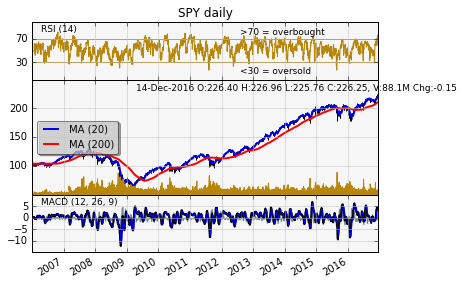

In [15]:
import datetime
import numpy as np
import matplotlib.colors as colors
import matplotlib.finance as finance
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager


startdate = datetime.date(2006, 1, 1)
today = enddate = datetime.date.today()
ticker = 'SPY'


fh = finance.fetch_historical_yahoo(ticker, startdate, enddate)
# a numpy record array with fields: date, open, high, low, close, volume, adj_close)

r = mlab.csv2rec(fh)
fh.close()
r.sort()


def moving_average(x, n, type='simple'):
    """
    compute an n period moving average.

    type is 'simple' | 'exponential'

    """
    x = np.asarray(x)
    if type == 'simple':
        weights = np.ones(n)
    else:
        weights = np.exp(np.linspace(-1., 0., n))

    weights /= weights.sum()

    a = np.convolve(x, weights, mode='full')[:len(x)]
    a[:n] = a[n]
    return a


def relative_strength(prices, n=14):
    """
    compute the n period relative strength indicator
    http://stockcharts.com/school/doku.php?id=chart_school:glossary_r#relativestrengthindex
    http://www.investopedia.com/terms/r/rsi.asp
    """

    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed >= 0].sum()/n
    down = -seed[seed < 0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1. + rs)

    for i in range(n, len(prices)):
        delta = deltas[i - 1]  # cause the diff is 1 shorter

        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up*(n - 1) + upval)/n
        down = (down*(n - 1) + downval)/n

        rs = up/down
        rsi[i] = 100. - 100./(1. + rs)

    return rsi


def moving_average_convergence(x, nslow=26, nfast=12):
    """
    compute the MACD (Moving Average Convergence/Divergence) using a fast and slow exponential moving avg'
    return value is emaslow, emafast, macd which are len(x) arrays
    """
    emaslow = moving_average(x, nslow, type='exponential')
    emafast = moving_average(x, nfast, type='exponential')
    return emaslow, emafast, emafast - emaslow


plt.rc('axes', grid=True)
plt.rc('grid', color='0.75', linestyle='-', linewidth=0.5)

textsize = 9
left, width = 0.1, 0.8
rect1 = [left, 0.7, width, 0.2]
rect2 = [left, 0.3, width, 0.4]
rect3 = [left, 0.1, width, 0.2]


fig = plt.figure(facecolor='white')
axescolor = '#f6f6f6'  # the axes background color

ax1 = fig.add_axes(rect1, axisbg=axescolor)  # left, bottom, width, height
ax2 = fig.add_axes(rect2, axisbg=axescolor, sharex=ax1)
ax2t = ax2.twinx()
ax3 = fig.add_axes(rect3, axisbg=axescolor, sharex=ax1)


# plot the relative strength indicator
prices = r.adj_close
rsi = relative_strength(prices)
fillcolor = 'darkgoldenrod'

ax1.plot(r.date, rsi, color=fillcolor)
ax1.axhline(70, color=fillcolor)
ax1.axhline(30, color=fillcolor)
ax1.fill_between(r.date, rsi, 70, where=(rsi >= 70), facecolor=fillcolor, edgecolor=fillcolor)
ax1.fill_between(r.date, rsi, 30, where=(rsi <= 30), facecolor=fillcolor, edgecolor=fillcolor)
ax1.text(0.6, 0.9, '>70 = overbought', va='top', transform=ax1.transAxes, fontsize=textsize)
ax1.text(0.6, 0.1, '<30 = oversold', transform=ax1.transAxes, fontsize=textsize)
ax1.set_ylim(0, 100)
ax1.set_yticks([30, 70])
ax1.text(0.025, 0.95, 'RSI (14)', va='top', transform=ax1.transAxes, fontsize=textsize)
ax1.set_title('%s daily' % ticker)

# plot the price and volume data
dx = r.adj_close - r.close
low = r.low + dx
high = r.high + dx

deltas = np.zeros_like(prices)
deltas[1:] = np.diff(prices)
up = deltas > 0
ax2.vlines(r.date[up], low[up], high[up], color='black', label='_nolegend_')
ax2.vlines(r.date[~up], low[~up], high[~up], color='black', label='_nolegend_')
ma20 = moving_average(prices, 20, type='simple')
ma200 = moving_average(prices, 200, type='simple')

linema20, = ax2.plot(r.date, ma20, color='blue', lw=2, label='MA (20)')
linema200, = ax2.plot(r.date, ma200, color='red', lw=2, label='MA (200)')


last = r[-1]
s = '%s O:%1.2f H:%1.2f L:%1.2f C:%1.2f, V:%1.1fM Chg:%+1.2f' % (
    today.strftime('%d-%b-%Y'),
    last.open, last.high,
    last.low, last.close,
    last.volume*1e-6,
    last.close - last.open)
t4 = ax2.text(0.3, 0.9, s, transform=ax2.transAxes, fontsize=textsize)

props = font_manager.FontProperties(size=10)
leg = ax2.legend(loc='center left', shadow=True, fancybox=True, prop=props)
leg.get_frame().set_alpha(0.5)


volume = (r.close*r.volume)/1e6  # dollar volume in millions
vmax = volume.max()
poly = ax2t.fill_between(r.date, volume, 0, label='Volume', facecolor=fillcolor, edgecolor=fillcolor)
ax2t.set_ylim(0, 5*vmax)
ax2t.set_yticks([])


# compute the MACD indicator
fillcolor = 'darkslategrey'
nslow = 26
nfast = 12
nema = 9
emaslow, emafast, macd = moving_average_convergence(prices, nslow=nslow, nfast=nfast)
ema9 = moving_average(macd, nema, type='exponential')
ax3.plot(r.date, macd, color='black', lw=2)
ax3.plot(r.date, ema9, color='blue', lw=1)
ax3.fill_between(r.date, macd - ema9, 0, alpha=0.5, facecolor=fillcolor, edgecolor=fillcolor)


ax3.text(0.025, 0.95, 'MACD (%d, %d, %d)' % (nfast, nslow, nema), va='top',
         transform=ax3.transAxes, fontsize=textsize)

#ax3.set_yticks([])
# turn off upper axis tick labels, rotate the lower ones, etc
for ax in ax1, ax2, ax2t, ax3:
    if ax != ax3:
        for label in ax.get_xticklabels():
            label.set_visible(False)
    else:
        for label in ax.get_xticklabels():
            label.set_rotation(30)
            label.set_horizontalalignment('right')

    ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')


class MyLocator(mticker.MaxNLocator):
    def __init__(self, *args, **kwargs):
        mticker.MaxNLocator.__init__(self, *args, **kwargs)

    def __call__(self, *args, **kwargs):
        return mticker.MaxNLocator.__call__(self, *args, **kwargs)

# at most 5 ticks, pruning the upper and lower so they don't overlap
# with other ticks
#ax2.yaxis.set_major_locator(mticker.MaxNLocator(5, prune='both'))
#ax3.yaxis.set_major_locator(mticker.MaxNLocator(5, prune='both'))

ax2.yaxis.set_major_locator(MyLocator(5, prune='both'))
ax3.yaxis.set_major_locator(MyLocator(5, prune='both'))

plt.show()

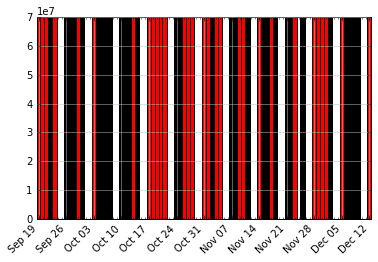

In [7]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc, volume_overlay3
import matplotlib.dates as mdates



mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
alldays = DayLocator()              # minor ticks on the days
weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
dayFormatter = DateFormatter('%d')      # e.g., 12

# make an array of tuples in the specific order needed for plotting
quotes = [tuple(x) for x in ticker[['NumDate', 'Open', 'High', 'Low', 'Close', 'Volume']].to_records(index=False)]
# volume = [tuple(x) for x in ticker[['NumDate', 'Open', 'High', 'Low', 'Close']].to_records(index=False)]

if len(quotes) == 0:
    raise SystemExit
# If the sequence is too long it won't plot correctly/well
# Absolute max is ~600
# Default to 60 (i.e. last 3 months)
if len(quotes) > 60:
    quotes = quotes[-60:]

fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)
ax.xaxis.set_major_locator(mondays)
ax.xaxis.set_minor_locator(alldays)
ax.xaxis.set_major_formatter(weekFormatter)
# Need to add $ formatting to y axis
#ax.xaxis.set_minor_formatter(dayFormatter)

#plot_day_summary(ax, quotes, ticksize=3)
candlestick_ohlc(ax, quotes, width=0.6)
plt.hold(True)
volume_overlay3(ax, quotes)


ax.xaxis_date()
ax.autoscale_view()
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

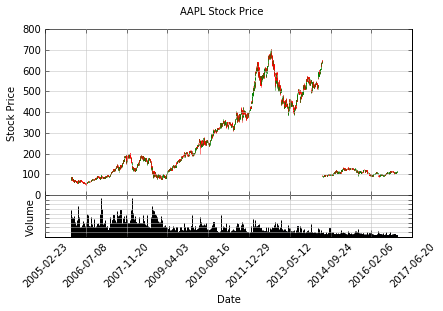

In [14]:
import matplotlib
# matplotlib.rcParams.update({'font size':9})

candleAr = quotes = [tuple(x) for x in ticker[['NumDate', 'Open', 'High', 'Low', 'Close', 'Volume']].to_records(index=False)]

fig = plt.figure()
# We use the subplot2grid to unnion to plots.
# (5,4) is the size of the plot, (0,0) is where it starts.
ax1 = plt.subplot2grid((5,4),(0,0),rowspan=4,colspan=4)
matplotlib.finance.candlestick_ohlc(ax1, candleAr, width = 0.75 , colorup = 'g', colordown = 'r')
plt.ylabel('Stock Price')
ax1.grid(True)

#New axis, with sharex = ax1. we link both grapich. if we zoom one the other will zoom too., and the dates change also.

ax2 = plt.subplot2grid((5,4),(4,0),sharex=ax1,rowspan=1,colspan=4)
ax2.bar(ticker["NumDate"],ticker["Volume"])

# With this code we remove al labels from xaxis from the first plot = ax1

ax2.axes.yaxis.set_ticklabels([])
plt.ylabel('Volume')
ax2.grid(True)

# this show a maximun of 10 dates.

ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)

for label in ax2.xaxis.get_ticklabels():
    label.set_rotation(45)

#plt.subplots_adjust(left=.10,bottom=.19, right=.93, top=.95 , wspace=.20 , hspace=.07)
            
plt.xlabel('Date')
plt.suptitle(asset+' Stock Price')

##We use this part of the code to disapear the label data from the X1 axis.

plt.setp(ax1.get_xticklabels(),visible=False)

##We use the subplot_adjust to make a unnion between our to plot. hspcae = 0.
## to make they really close.

plt.subplots_adjust(left=0.09,bottom=.18,right=.94,wspace=.20,hspace=0)
plt.show()